In [18]:
import matplotlib.pyplot as plt
import aplpy
#matplotlib.rc("font", size=18)
import soxs
import astropy.units as u
from astropy.coordinates import SkyCoord
import subprocess #for running scripts
import os
import numpy as np


In [19]:
nhtor = [22,23,24] # torus column density
#nhlos = [1.e+22,1.e+23,1.e+24] # los of sight column density
z = 0.05 # redshifts
view_angle = 70
open_angle = np.degrees(np.arccos(0.85)) # here we're choosing a covering factor of 85%
#np.cos(np.radians(60))
#np.degrees(np.arccos(0.85))

In [20]:
# Here we are establishing the models for the borus models
def model_borus(z,angle,emin,emax,norm):
    model = "tbabs*(atable{/Users/ryan/Dropbox/GitHub/SOXS/LEM/borus02_v170323c.fits}+ztbabs*cabs*zcutoffpl+const*zcutoffpl+apec+apec)" # A somewhat complicated model
    galnh = 1.0e-2
    emin = emin
    emax = emax
    nbins = 20000
    theta=angle
    flux = norm # erg/s/cm**2
    borus1 = []
    nh_tab1 = []
    borus2 = []
    nh_tab2 = []
    for nh1 in nhtor:
        for nh2 in nhtor:
            params = [galnh,1.8,300,nh1,open_angle,theta,1.0,z,1.0e-3,((10**nh1)/(1.e+22)),z,((10**nh1)/(1.e+22)),1.8,300,z,1.e-3,0.005,1.8,300,z,1.e-3,0.1,1.0,z,1.e-3,0.90,1.0,z,1.e-3]    
            # For the 1st AGN
            spec1 = soxs.spectra.Spectrum.from_xspec_model(model, params, emin, emax, nbins)
            spec1.rescale_flux(1.e-13, emin=(2/(z+1)), emax=(10/(z+1)), flux_type="energy")
            borus1.append(spec1)
            nh_tab1.append(nh1)
            # For the 2nd AGN now:
            params = [galnh,1.8,300,nh2,60,theta,1.0,z,1.0e-3,((10**nh2)/(1.e+22)),z,((10**nh2)/(1.e+22)),1.8,300,z,1.e-3,0.005,1.8,300,z,1.e-3,0.3,1.0,z,1.e-3,0.65,1.0,z,1.e-3]    
            spec2 = soxs.spectra.Spectrum.from_xspec_model(model, params, emin, emax, nbins)
            spec2.rescale_flux(flux, emin=(2/(z+1)), emax=(10/(z+1)), flux_type="energy")
            borus2.append(spec2)
            nh_tab2.append(nh2)
    return borus1, nh_tab1, borus2, nh_tab2

# FLUXES OF 1.E-14 ARE TOO DIM!

In [21]:
borus1, nh_tab1, borus2, nh_tab2, = model_borus(z,view_angle,0.1,100.0,5.e-14)


In [5]:
#borus1[2]

In [22]:
from soxs import PointSourceModel
from soxs import write_spectrum
from soxs import plot_spectrum

# Center of the field of view
ra0 = 30.0 # degrees
dec0 = 45.0 # degrees

# Create a list of RA and Dec offsets that we'll load into a function to generate a series of point sources \
# at varying separations
c0 = SkyCoord(ra0*u.deg, dec0*u.deg, frame='icrs')
c1 = SkyCoord(ra0*u.deg, dec0*u.deg, frame='icrs') 

sep=['50','40','30','20','18','16','15','14','12','10','8','6','5','4','2','0']
ras1 = [c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra]
decs1 = [c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec]

ras2 = []
decs2 = []
for i in sep:
    c2 = c0.directional_offset_by(90 * u.deg, int(i) * u.arcsec) 
    ras2.append(c2.ra)
    decs2.append(c2.dec)

#print(ras2)
#print(decs2)

In [23]:
os.getcwd()
#os.chdir('../')

'/Users/ryan/Dropbox/GitHub/SOXS/HEXP'

In [24]:
def sim_duals(ras1, decs1, ras2, decs2, sep, exp, borus1, nh_tab1, borus2, nh_tab2):
    for i,j,x,y,k in zip(ras1,decs1,ras2,decs2,sep):
        # Making directory for the particular separation in question
        if not os.path.exists('Sep_'+str(k)+'as/'):
            os.mkdir('Sep_'+str(k)+'as/')
        os.chdir('Sep_'+str(k)+'as/')
        print('Now working in directory: ' + os.getcwd())
        #Now creating the spatial models
        pt_src1 = PointSourceModel(i, j) # AGN1
        pt_src2 = PointSourceModel(x, y) # AGN2
        ###### Now generating source region apertures for the sources
        rad=10
        str1 = 'circle('+str(i/u.deg)+','+str(j/u.deg)+','+str(rad)+'''\"'''+')' #+'''\\''' + '\"' 
        str2 = 'circle('+str(x/u.deg)+','+str(y/u.deg)+','+str(rad)+'''\"'''+')' #+'''\\''' + '\"' 
        with open("cir1_"+str(k)+".reg", 'w') as reg1:
            reg1.write('# Region file format: DS9 version 4.1 \n')
            reg1.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            reg1.write('fk5 \n')
            reg1.write(str1) 
        with open("cir2_"+str(k)+".reg", 'w') as reg2:
            reg2.write('# Region file format: DS9 version 4.1 \n')
            reg2.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            reg2.write('fk5 \n')
            reg2.write(str2) 
        ##### Now generating a background region that we will compare to
        str3 = 'circle('+str(29.9916000)+','+str(45.0483000)+','+str(60)+'''\"'''+')' #+'''\\''' + '\"'
        with open("bkg_"+str(k)+".reg", 'w') as reg3:
            reg3.write('# Region file format: DS9 version 4.1 \n')
            reg3.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            reg3.write('fk5 \n')
            reg3.write(str3) 
        # Now adding a loop to generate simputs for the different combos of AGN1 and AGN2
        for spec1,spec2,nh1,nh2 in zip(borus1, borus2, nh_tab1, nh_tab2):
            # Generating the simput photon distributions convolved with a spatial model
            sou1_phlist = soxs.SimputPhotonList.from_models("AGN 1", spec1, pt_src1, (500.0, "ks"), (3.0, "m**2"))
            sou2_phlist = soxs.SimputPhotonList.from_models("AGN 2", spec2, pt_src2, (500.0, "ks"), (3.0, "m**2"))
            # Create the SIMPUT catalog "sim_cat" from the photon lists "AGN1" and "AGN2"
            NHflag="_NH1_"+str(nh1)+"_NH2_"+str(nh2)
            sim_cat = soxs.SimputCatalog.from_source("dualagn_"+str(k)+"as_simput"+str(NHflag)+".fits", sou1_phlist, overwrite=True)
            sim_cat.append(sou2_phlist)
            # Here we are interfacing with SIXTE with a bash script to generate event files, science images, and spectra
            #%run sixte_duals_simulations.sh sep ras1 decs1 exp # Running the sixte simulations now
            sim = subprocess.run('/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh '+ str(k) + ' ' + str(i/u.deg) + ' ' + str(j/u.deg) + ' ' + str(exp) + ' ' + str(NHflag), shell=True)
            print(sim)
            # This takes in arguments for the separation, ra1 and dec1, and the exposure time choice
            # These are needed for naming conventions, assignment of the observation pointing, and the exposure time
        os.chdir('../')


In [11]:
(10**2)/(60**2)


0.027777777777777776

In [12]:
(60**2)/(10**2)

36.0

In [25]:
#os.chdir('HEXP/')
os.getcwd()

'/Users/ryan/Dropbox/GitHub/SOXS/HEXP'

In [ ]:
if not os.path.exists('Borus_nustar/'):
    os.mkdir('Borus_nustar/')
os.chdir('Borus_nustar/')

sim_duals(ras1, decs1, ras2, decs2, sep, 50000, borus1, nh_tab1, borus2, nh_tab2)

os.chdir('../')

soxs : [INFO     ] 2023-05-22 16:50:42,055 Creating 2644551 energies from this spectrum.


Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus_nustar/Sep_50as


soxs : [INFO     ] 2023-05-22 16:50:42,373 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:50:42,522 Creating 1535295 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:50:42,682 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:50:42,844 Appending source 'AGN 1' to dualagn_50as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 16:50:43,407 Appending source 'AGN 2' to dualagn_50as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:51:05,075 Creating 2647601 energies from this spectrum.


initialize ...
open event file 'sixtesim_50as_evt50ks_2FPMeff_NH1_22_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 50 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 16:51:05,372 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:51:05,563 Creating 2413432 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:51:05,863 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:51:06,082 Appending source 'AGN 1' to dualagn_50as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 16:51:06,727 Appending source 'AGN 2' to dualagn_50as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:51:27,144 Creating 2646603 energies from this spectrum.


initialize ...
open event file 'sixtesim_50as_evt50ks_2FPMeff_NH1_22_NH2_23_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 50 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-22 16:51:27,472 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:51:27,633 Creating 15489164 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:51:29,604 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:51:30,941 Appending source 'AGN 1' to dualagn_50as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-22 16:51:31,836 Appending source 'AGN 2' to dualagn_50as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:51:58,307 Creating 3956762 energies from this spectrum.


initialize ...
open event file 'sixtesim_50as_evt50ks_2FPMeff_NH1_22_NH2_24_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 50 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-22 16:51:58,755 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:51:59,125 Creating 1532913 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:51:59,332 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:51:59,599 Appending source 'AGN 1' to dualagn_50as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 16:52:00,513 Appending source 'AGN 2' to dualagn_50as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:52:22,136 Creating 3957686 energies from this spectrum.


initialize ...
open event file 'sixtesim_50as_evt50ks_2FPMeff_NH1_23_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 50 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 16:52:22,601 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:52:22,898 Creating 2410845 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:52:23,160 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:52:23,403 Appending source 'AGN 1' to dualagn_50as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 16:52:24,471 Appending source 'AGN 2' to dualagn_50as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:52:46,632 Creating 3961327 energies from this spectrum.


initialize ...
open event file 'sixtesim_50as_evt50ks_2FPMeff_NH1_23_NH2_23_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 50 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-22 16:52:47,077 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:52:47,446 Creating 15481410 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:52:49,453 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:52:50,574 Appending source 'AGN 1' to dualagn_50as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-22 16:52:51,799 Appending source 'AGN 2' to dualagn_50as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:53:17,133 Creating 19460569 energies from this spectrum.


initialize ...
open event file 'sixtesim_50as_evt50ks_2FPMeff_NH1_23_NH2_24_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 50 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-22 16:53:19,557 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:53:21,124 Creating 1535553 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:53:21,290 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:53:21,807 Appending source 'AGN 1' to dualagn_50as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 16:53:25,978 Appending source 'AGN 2' to dualagn_50as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:53:49,720 Creating 19460847 energies from this spectrum.


initialize ...
open event file 'sixtesim_50as_evt50ks_2FPMeff_NH1_24_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 50 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 16:53:52,076 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:53:53,513 Creating 2411906 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:53:53,771 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:53:54,277 Appending source 'AGN 1' to dualagn_50as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 16:53:58,860 Appending source 'AGN 2' to dualagn_50as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:54:22,641 Creating 19463327 energies from this spectrum.


initialize ...
open event file 'sixtesim_50as_evt50ks_2FPMeff_NH1_24_NH2_23_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 50 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-22 16:54:24,967 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:54:26,418 Creating 15479219 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:54:28,262 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:54:29,434 Appending source 'AGN 1' to dualagn_50as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-22 16:54:33,977 Appending source 'AGN 2' to dualagn_50as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:55:02,196 Creating 2648692 energies from this spectrum.


initialize ...
open event file 'sixtesim_50as_evt50ks_2FPMeff_NH1_24_NH2_24_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 50 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus_nustar/Sep_40as


soxs : [INFO     ] 2023-05-22 16:55:02,488 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:55:02,681 Creating 1533733 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:55:02,838 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:55:03,047 Appending source 'AGN 1' to dualagn_40as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 16:55:04,052 Appending source 'AGN 2' to dualagn_40as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:55:24,921 Creating 2644067 energies from this spectrum.


initialize ...
open event file 'sixtesim_40as_evt50ks_2FPMeff_NH1_22_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 40 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 16:55:25,223 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:55:25,397 Creating 2408456 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:55:25,667 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:55:25,949 Appending source 'AGN 1' to dualagn_40as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 16:55:26,646 Appending source 'AGN 2' to dualagn_40as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:55:47,792 Creating 2646046 energies from this spectrum.


initialize ...
open event file 'sixtesim_40as_evt50ks_2FPMeff_NH1_22_NH2_23_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 40 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-22 16:55:48,085 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:55:48,243 Creating 15487014 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:55:50,150 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:55:51,287 Appending source 'AGN 1' to dualagn_40as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-22 16:55:52,398 Appending source 'AGN 2' to dualagn_40as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:56:17,993 Creating 3956626 energies from this spectrum.


initialize ...
open event file 'sixtesim_40as_evt50ks_2FPMeff_NH1_22_NH2_24_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 40 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-22 16:56:18,452 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:56:18,710 Creating 1534043 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:56:18,872 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:56:19,117 Appending source 'AGN 1' to dualagn_40as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 16:56:20,235 Appending source 'AGN 2' to dualagn_40as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:56:41,186 Creating 3957338 energies from this spectrum.


initialize ...
open event file 'sixtesim_40as_evt50ks_2FPMeff_NH1_23_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 40 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 16:56:41,629 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:56:41,911 Creating 2408984 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:56:42,165 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:56:42,503 Appending source 'AGN 1' to dualagn_40as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 16:56:43,540 Appending source 'AGN 2' to dualagn_40as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:57:05,215 Creating 3958884 energies from this spectrum.


initialize ...
open event file 'sixtesim_40as_evt50ks_2FPMeff_NH1_23_NH2_23_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 40 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-22 16:57:05,656 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:57:05,939 Creating 15485604 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:57:07,758 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:57:08,847 Appending source 'AGN 1' to dualagn_40as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-22 16:57:10,320 Appending source 'AGN 2' to dualagn_40as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:57:37,696 Creating 19464628 energies from this spectrum.


initialize ...
open event file 'sixtesim_40as_evt50ks_2FPMeff_NH1_23_NH2_24_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 40 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-22 16:57:40,109 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:57:41,799 Creating 1533612 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:57:41,961 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:57:42,495 Appending source 'AGN 1' to dualagn_40as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 16:57:47,821 Appending source 'AGN 2' to dualagn_40as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:58:12,126 Creating 19453334 energies from this spectrum.


initialize ...
open event file 'sixtesim_40as_evt50ks_2FPMeff_NH1_24_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 40 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 16:58:14,485 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:58:16,002 Creating 2409937 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:58:16,271 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:58:16,839 Appending source 'AGN 1' to dualagn_40as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 16:58:22,122 Appending source 'AGN 2' to dualagn_40as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:58:46,589 Creating 19456389 energies from this spectrum.


initialize ...
open event file 'sixtesim_40as_evt50ks_2FPMeff_NH1_24_NH2_23_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 40 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-22 16:58:48,939 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:58:50,211 Creating 15489823 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:58:52,070 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:58:53,229 Appending source 'AGN 1' to dualagn_40as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-22 16:58:58,390 Appending source 'AGN 2' to dualagn_40as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:59:27,027 Creating 2645103 energies from this spectrum.


initialize ...
open event file 'sixtesim_40as_evt50ks_2FPMeff_NH1_24_NH2_24_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 40 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus_nustar/Sep_30as


soxs : [INFO     ] 2023-05-22 16:59:27,320 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:59:27,499 Creating 1532688 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:59:27,664 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:59:27,825 Appending source 'AGN 1' to dualagn_30as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 16:59:28,624 Appending source 'AGN 2' to dualagn_30as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 16:59:49,293 Creating 2646859 energies from this spectrum.


initialize ...
open event file 'sixtesim_30as_evt50ks_2FPMeff_NH1_22_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 30 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 16:59:49,585 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:59:49,746 Creating 2412045 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 16:59:50,010 Finished creating energies.
soxs : [INFO     ] 2023-05-22 16:59:50,228 Appending source 'AGN 1' to dualagn_30as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 16:59:51,041 Appending source 'AGN 2' to dualagn_30as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:00:11,283 Creating 2648738 energies from this spectrum.


initialize ...
open event file 'sixtesim_30as_evt50ks_2FPMeff_NH1_22_NH2_23_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 30 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-22 17:00:11,584 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:00:11,766 Creating 15487991 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:00:13,634 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:00:14,588 Appending source 'AGN 1' to dualagn_30as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-22 17:00:15,660 Appending source 'AGN 2' to dualagn_30as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:00:41,195 Creating 3956195 energies from this spectrum.


initialize ...
open event file 'sixtesim_30as_evt50ks_2FPMeff_NH1_22_NH2_24_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 30 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-22 17:00:41,637 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:00:41,894 Creating 1535205 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:00:42,053 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:00:42,289 Appending source 'AGN 1' to dualagn_30as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 17:00:43,496 Appending source 'AGN 2' to dualagn_30as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:01:06,253 Creating 3958450 energies from this spectrum.


initialize ...
open event file 'sixtesim_30as_evt50ks_2FPMeff_NH1_23_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 30 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 17:01:06,687 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:01:06,954 Creating 2409199 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:01:07,213 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:01:07,470 Appending source 'AGN 1' to dualagn_30as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 17:01:08,634 Appending source 'AGN 2' to dualagn_30as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:01:29,149 Creating 3956229 energies from this spectrum.


initialize ...
open event file 'sixtesim_30as_evt50ks_2FPMeff_NH1_23_NH2_23_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 30 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-22 17:01:29,578 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:01:29,811 Creating 15487578 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:01:31,604 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:01:32,490 Appending source 'AGN 1' to dualagn_30as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-22 17:01:33,901 Appending source 'AGN 2' to dualagn_30as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:01:59,882 Creating 19469073 energies from this spectrum.


initialize ...
open event file 'sixtesim_30as_evt50ks_2FPMeff_NH1_23_NH2_24_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 30 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-22 17:02:02,282 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:02:03,808 Creating 1531741 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:02:03,973 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:02:04,506 Appending source 'AGN 1' to dualagn_30as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 17:02:08,838 Appending source 'AGN 2' to dualagn_30as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:02:33,230 Creating 19462979 energies from this spectrum.


initialize ...
open event file 'sixtesim_30as_evt50ks_2FPMeff_NH1_24_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 30 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 17:02:35,579 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:02:37,034 Creating 2409283 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:02:37,301 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:02:37,798 Appending source 'AGN 1' to dualagn_30as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 17:02:43,614 Appending source 'AGN 2' to dualagn_30as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:03:10,358 Creating 19459422 energies from this spectrum.


initialize ...
open event file 'sixtesim_30as_evt50ks_2FPMeff_NH1_24_NH2_23_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 30 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-22 17:03:12,722 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:03:14,166 Creating 15489241 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:03:16,089 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:03:17,309 Appending source 'AGN 1' to dualagn_30as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-22 17:03:33,412 Appending source 'AGN 2' to dualagn_30as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:04:11,571 Creating 2644674 energies from this spectrum.


initialize ...
open event file 'sixtesim_30as_evt50ks_2FPMeff_NH1_24_NH2_24_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 30 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus_nustar/Sep_20as


soxs : [INFO     ] 2023-05-22 17:04:11,862 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:04:12,046 Creating 1532936 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:04:12,212 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:04:12,407 Appending source 'AGN 1' to dualagn_20as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 17:04:13,903 Appending source 'AGN 2' to dualagn_20as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:04:37,559 Creating 2644059 energies from this spectrum.


initialize ...
open event file 'sixtesim_20as_evt50ks_2FPMeff_NH1_22_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 20 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 17:04:37,840 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:04:37,998 Creating 2412902 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:04:38,254 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:04:38,441 Appending source 'AGN 1' to dualagn_20as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 17:04:39,741 Appending source 'AGN 2' to dualagn_20as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:05:04,029 Creating 2646652 energies from this spectrum.


initialize ...
open event file 'sixtesim_20as_evt50ks_2FPMeff_NH1_22_NH2_23_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 20 30.0 45.0 50000 _NH1_22_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-22 17:05:04,323 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:05:04,476 Creating 15488453 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:05:06,373 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:05:07,336 Appending source 'AGN 1' to dualagn_20as_simput_NH1_22_NH2_24.fits.
soxs : [INFO     ] 2023-05-22 17:05:09,115 Appending source 'AGN 2' to dualagn_20as_simput_NH1_22_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:05:40,542 Creating 3961001 energies from this spectrum.


initialize ...
open event file 'sixtesim_20as_evt50ks_2FPMeff_NH1_22_NH2_24_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 20 30.0 45.0 50000 _NH1_22_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-22 17:05:40,987 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:05:41,251 Creating 1536799 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:05:41,410 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:05:41,678 Appending source 'AGN 1' to dualagn_20as_simput_NH1_23_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 17:05:43,519 Appending source 'AGN 2' to dualagn_20as_simput_NH1_23_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:06:06,918 Creating 3956603 energies from this spectrum.


initialize ...
open event file 'sixtesim_20as_evt50ks_2FPMeff_NH1_23_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 20 30.0 45.0 50000 _NH1_23_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 17:06:07,357 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:06:07,611 Creating 2408993 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:06:07,865 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:06:08,112 Appending source 'AGN 1' to dualagn_20as_simput_NH1_23_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 17:06:10,003 Appending source 'AGN 2' to dualagn_20as_simput_NH1_23_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:06:34,018 Creating 3960115 energies from this spectrum.


initialize ...
open event file 'sixtesim_20as_evt50ks_2FPMeff_NH1_23_NH2_23_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 20 30.0 45.0 50000 _NH1_23_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-22 17:06:34,467 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:06:34,729 Creating 15483294 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:06:36,552 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:06:37,475 Appending source 'AGN 1' to dualagn_20as_simput_NH1_23_NH2_24.fits.
soxs : [INFO     ] 2023-05-22 17:06:39,929 Appending source 'AGN 2' to dualagn_20as_simput_NH1_23_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:07:11,264 Creating 19460280 energies from this spectrum.


initialize ...
open event file 'sixtesim_20as_evt50ks_2FPMeff_NH1_23_NH2_24_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 20 30.0 45.0 50000 _NH1_23_NH2_24', returncode=0)


soxs : [INFO     ] 2023-05-22 17:07:13,650 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:07:15,121 Creating 1531046 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:07:15,295 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:07:15,806 Appending source 'AGN 1' to dualagn_20as_simput_NH1_24_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 17:07:27,147 Appending source 'AGN 2' to dualagn_20as_simput_NH1_24_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:07:54,550 Creating 19463559 energies from this spectrum.


initialize ...
open event file 'sixtesim_20as_evt50ks_2FPMeff_NH1_24_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 20 30.0 45.0 50000 _NH1_24_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 17:07:56,907 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:07:58,365 Creating 2410213 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:07:58,631 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:07:59,135 Appending source 'AGN 1' to dualagn_20as_simput_NH1_24_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 17:08:10,545 Appending source 'AGN 2' to dualagn_20as_simput_NH1_24_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:08:38,012 Creating 19470271 energies from this spectrum.


initialize ...
open event file 'sixtesim_20as_evt50ks_2FPMeff_NH1_24_NH2_23_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 20 30.0 45.0 50000 _NH1_24_NH2_23', returncode=0)


soxs : [INFO     ] 2023-05-22 17:08:40,423 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:08:41,782 Creating 15484388 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:08:43,667 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:08:44,891 Appending source 'AGN 1' to dualagn_20as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-05-22 17:08:51,851 Appending source 'AGN 2' to dualagn_20as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:09:24,456 Creating 2644848 energies from this spectrum.


initialize ...
open event file 'sixtesim_20as_evt50ks_2FPMeff_NH1_24_NH2_24_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 20 30.0 45.0 50000 _NH1_24_NH2_24', returncode=0)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Borus_nustar/Sep_18as


soxs : [INFO     ] 2023-05-22 17:09:24,746 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:09:24,922 Creating 1532055 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:09:25,115 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:09:25,282 Appending source 'AGN 1' to dualagn_18as_simput_NH1_22_NH2_22.fits.
soxs : [INFO     ] 2023-05-22 17:09:26,253 Appending source 'AGN 2' to dualagn_18as_simput_NH1_22_NH2_22.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

soxs : [INFO     ] 2023-05-22 17:09:51,304 Creating 2649795 energies from this spectrum.


initialize ...
open event file 'sixtesim_18as_evt50ks_2FPMeff_NH1_22_NH2_22_3-78.fits' ...
finished successfully!

CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh 18 30.0 45.0 50000 _NH1_22_NH2_22', returncode=0)


soxs : [INFO     ] 2023-05-22 17:09:51,595 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:09:51,774 Creating 2413369 energies from this spectrum.
soxs : [INFO     ] 2023-05-22 17:09:52,034 Finished creating energies.
soxs : [INFO     ] 2023-05-22 17:09:52,222 Appending source 'AGN 1' to dualagn_18as_simput_NH1_22_NH2_23.fits.
soxs : [INFO     ] 2023-05-22 17:09:56,389 Appending source 'AGN 2' to dualagn_18as_simput_NH1_22_NH2_23.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/ryan/simput/share/instruments/nustar/nuAcutdet0_20100101v003.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

The following mandatory keywords are missing from the EBOUNDS extension:
 FILTER 
The following mandatory keywords are missing from the MATRIX extension:
 FILTER 

=== End of RMF validity check report ===

***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find LO_THRES keyword - setting it to 0.000000
***SPII_read_key: Cannot find NUMGRP keyword - setting it to 0
***SPII_read_key: Cannot find NUMELT keyword - setting it to 0
***SPII_read_key: Cannot find FILTER keyword - 

In [55]:
def simxim(image,ang,instr,band,nrow,ncol,index):
    vminx, vmaxx = 0.1, 1.5   # For the X-ray image
    width, height = 2./60., 2./60.
    ra, dec = 30.0, 45.0
    scl = 10
    f1 = aplpy.FITSFigure(image, downsample=False, figure = fig, subplot=(nrow,ncol,index))
    f1.show_colorscale(vmin=vminx, vmax=vmaxx, cmap='magma', stretch='log', smooth=3, kernel='gauss',) #smooth=3, kernel='gauss', 
    f1.recenter(ra, dec, width=width, height=height)
    #f1.show_circles(ra, dec, (45/(60*60)), color='white', linestyle='--', linewidth=2)
    f1.add_scalebar(scl/(60*60.))
    f1.scalebar.set_label('%s"' % scl)
    f1.scalebar.set_color('white')
    f1.scalebar.set_font_size(26)
    f1.ticks.hide()
    f1.tick_labels.hide()
    f1.axis_labels.hide()
    f1.frame.set_color('white')
    f1.add_label(0.17, 0.92, 'Sep='+str(ang)+u'\u2033', relative=True, size=26, color='white')
    f1.add_label(0.24, 0.07, band, relative=True, size=26, color='white')
    f1.add_label(0.7, 0.92, instr, relative=True, size=26, color='white')
    

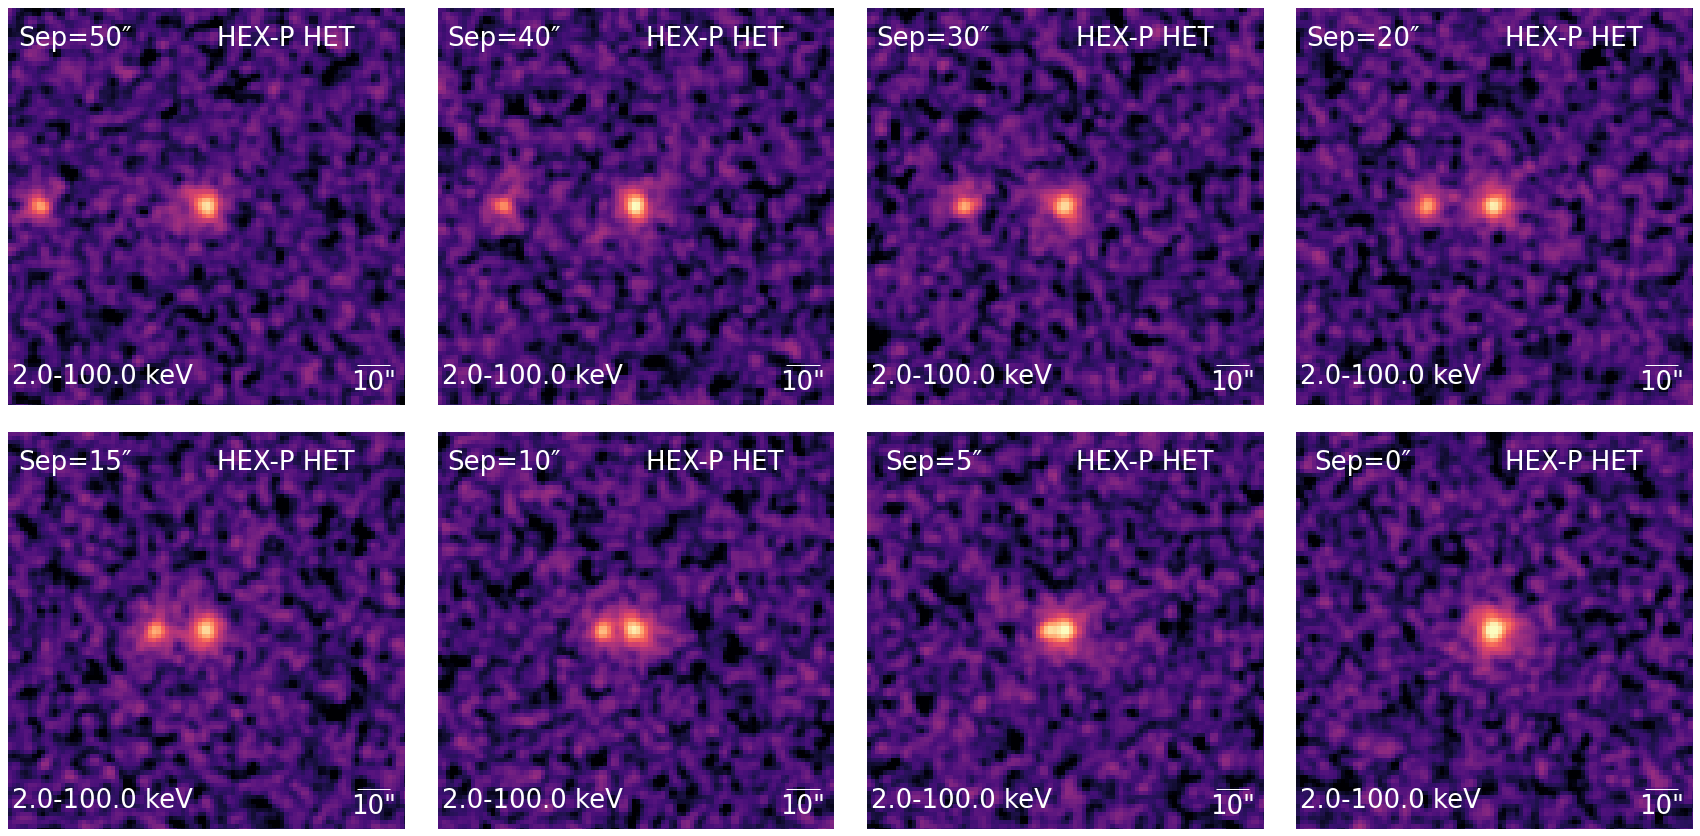

In [32]:
fig = plt.figure(figsize=(24,12))

simxim('Sep_50as/IMAGE_50as_img50ks_2HETeff_NH1_22_NH2_22.fits', 50, "HEX-P HET", "2.0-100.0 keV", 2, 4, 1)
simxim('Sep_40as/IMAGE_40as_img50ks_2HETeff_NH1_22_NH2_22.fits', 40, "HEX-P HET", "2.0-100.0 keV", 2, 4, 2)
simxim('Sep_30as/IMAGE_30as_img50ks_2HETeff_NH1_22_NH2_22.fits', 30, "HEX-P HET", "2.0-100.0 keV", 2, 4, 3)
simxim('Sep_20as/IMAGE_20as_img50ks_2HETeff_NH1_22_NH2_22.fits', 20, "HEX-P HET", "2.0-100.0 keV", 2, 4, 4)
simxim('Sep_15as/IMAGE_15as_img50ks_2HETeff_NH1_22_NH2_22.fits', 15, "HEX-P HET", "2.0-100.0 keV", 2, 4, 5)
simxim('Sep_10as/IMAGE_10as_img50ks_2HETeff_NH1_22_NH2_22.fits', 10, "HEX-P HET", "2.0-100.0 keV", 2, 4, 6)
simxim('Sep_5as/IMAGE_5as_img50ks_2HETeff_NH1_22_NH2_22.fits',   5, "HEX-P HET", "2.0-100.0 keV", 2, 4, 7)
simxim('Sep_0as/IMAGE_0as_img50ks_2HETeff_NH1_22_NH2_22.fits',   0, "HEX-P HET", "2.0-100.0 keV", 2, 4, 8)

plt.tight_layout()
plt.savefig('HEX-P_hardxray_imaging_grid_smoothed.png', dpi=150)

plt.show()


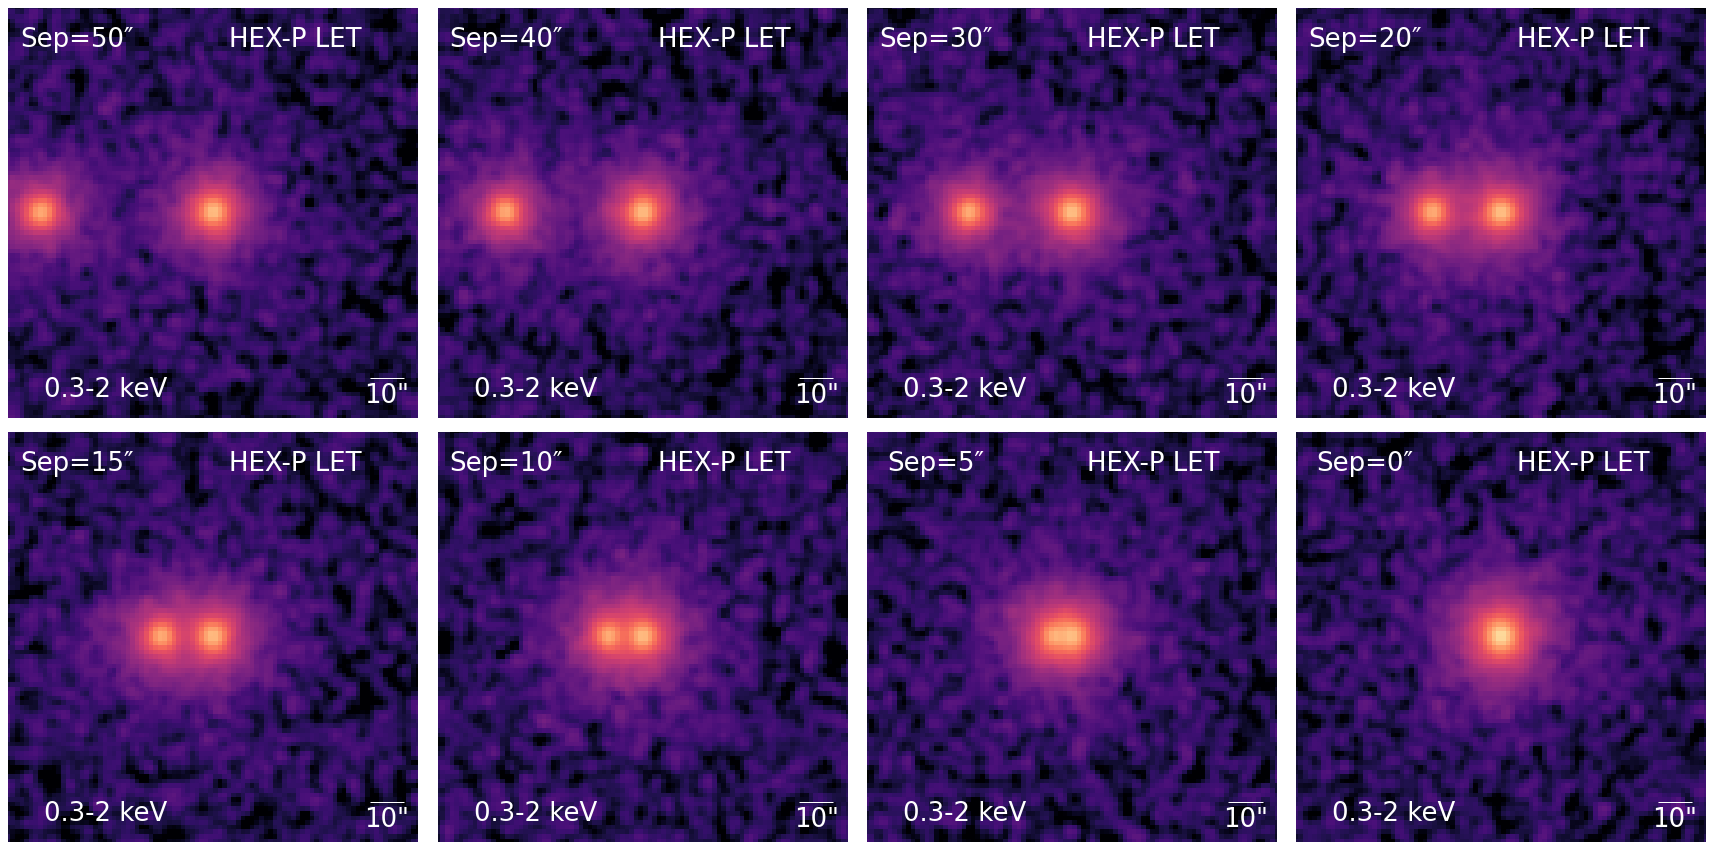

In [21]:
fig = plt.figure(figsize=(24,12))

simxim('Sep_50as/IMAGE_50as_img50ks_LET_NH1_22_NH2_22.fits', 50, "HEX-P LET", "0.3-2 keV", 2, 4, 1)
simxim('Sep_40as/IMAGE_40as_img50ks_LET_NH1_22_NH2_22.fits', 40, "HEX-P LET", "0.3-2 keV", 2, 4, 2)
simxim('Sep_30as/IMAGE_30as_img50ks_LET_NH1_22_NH2_22.fits', 30, "HEX-P LET", "0.3-2 keV", 2, 4, 3)
simxim('Sep_20as/IMAGE_20as_img50ks_LET_NH1_22_NH2_22.fits', 20, "HEX-P LET", "0.3-2 keV", 2, 4, 4)
simxim('Sep_15as/IMAGE_15as_img50ks_LET_NH1_22_NH2_22.fits', 15, "HEX-P LET", "0.3-2 keV", 2, 4, 5)
simxim('Sep_10as/IMAGE_10as_img50ks_LET_NH1_22_NH2_22.fits', 10, "HEX-P LET", "0.3-2 keV", 2, 4, 6)
simxim('Sep_5as/IMAGE_5as_img50ks_LET_NH1_22_NH2_22.fits',   5, "HEX-P LET", "0.3-2 keV", 2, 4, 7)
simxim('Sep_0as/IMAGE_0as_img50ks_LET_NH1_22_NH2_22.fits',   0, "HEX-P LET", "0.3-2 keV", 2, 4, 8)

plt.tight_layout()
plt.savefig('HEX-P_LETxray_imaging_grid_smoothed.png', dpi=150)

plt.show()



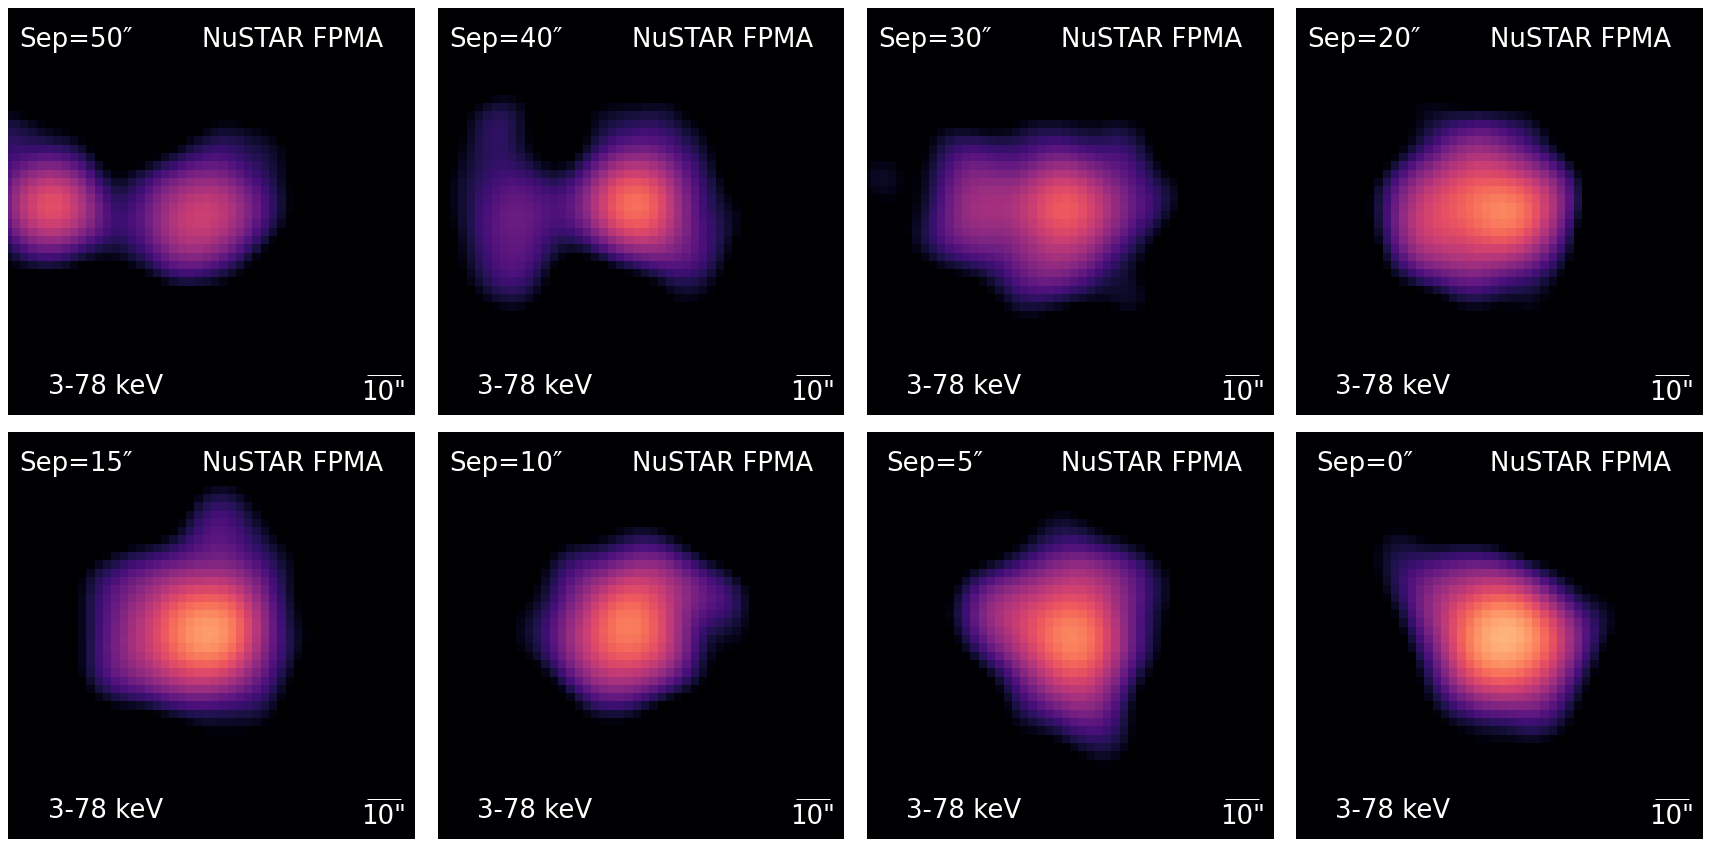

In [56]:
fig = plt.figure(figsize=(24,12))

simxim('Sep_50as/IMAGE_50as_img50ks_FPMA_NH1_22_NH2_22.fits', 50, "NuSTAR FPMA", "3-78 keV", 2, 4, 1)
simxim('Sep_40as/IMAGE_40as_img50ks_FPMA_NH1_22_NH2_22.fits', 40, "NuSTAR FPMA", "3-78 keV", 2, 4, 2)
simxim('Sep_30as/IMAGE_30as_img50ks_FPMA_NH1_22_NH2_22.fits', 30, "NuSTAR FPMA", "3-78 keV", 2, 4, 3)
simxim('Sep_20as/IMAGE_20as_img50ks_FPMA_NH1_22_NH2_22.fits', 20, "NuSTAR FPMA", "3-78 keV", 2, 4, 4)
simxim('Sep_15as/IMAGE_15as_img50ks_FPMA_NH1_22_NH2_22.fits', 15, "NuSTAR FPMA", "3-78 keV", 2, 4, 5)
simxim('Sep_10as/IMAGE_10as_img50ks_FPMA_NH1_22_NH2_22.fits', 10, "NuSTAR FPMA", "3-78 keV", 2, 4, 6)
simxim('Sep_5as/IMAGE_5as_img50ks_FPMA_NH1_22_NH2_22.fits',   5, "NuSTAR FPMA", "3-78 keV", 2, 4, 7)
simxim('Sep_0as/IMAGE_0as_img50ks_FPMA_NH1_22_NH2_22.fits',   0, "NuSTAR FPMA", "3-78 keV", 2, 4, 8)

plt.tight_layout()
plt.savefig('HEX-P_FPMAxray_imaging_grid_smoothed.png', dpi=150)

plt.show()




In [57]:
os.chdir('Finer_sep_grid/')
os.getcwd()

'/Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid'

In [59]:
nhtor = [24] # torus column density
#nhlos = [1.e+22,1.e+23,1.e+24] # los of sight column density
z = 0.05 # redshifts
angle = 70

In [60]:
# Here we are establishing the models for the borus models
def model_borus(z,angle,emin,emax,norm):
    model = "tbabs*(atable{/Users/ryan/Dropbox/GitHub/SOXS/LEM/borus02_v170323c.fits}+ztbabs*cabs*zcutoffpl+const*zcutoffpl+apec+apec)" # A somewhat complicated model
    galnh = 1.0e-2
    emin = emin
    emax = emax
    nbins = 20000
    theta=angle
    flux = norm # erg/s/cm**2 # This is what we're rescaling the 2-10 keV band to, but we want this in the ~0.4-2 band which is ~2-10
    # I think actually 2-10 is --> 0.44-2.22
    #thetalist1 = []
    borus1 = []
    nh_tab1 = []
    #thetalist2 = []
    borus2 = []
    nh_tab2 = []
    for nh1 in nhtor:
        for nh2 in nhtor:
            #for i, j, k in zip(z2,vellista,z1):
            #for theta in angle:
            params = [galnh,1.8,300,nh1,60,theta,1.0,z,1.0e-3,((10**nh1)/(1.e+22)),z,((10**nh1)/(1.e+22)),1.8,300,z,1.e-3,0.005,1.8,300,z,1.e-3,0.1,1.0,z,1.e-3,0.90,1.0,z,1.e-3]    
            # For the 1st AGN
            spec1 = soxs.spectra.Spectrum.from_xspec_model(model, params, emin, emax, nbins)
            spec1.rescale_flux(1.e-13, emin=(2/(z+1)), emax=(10/(z+1)), flux_type="energy")
            borus1.append(spec1)
            nh_tab1.append(nh1)
            # For the 2nd AGN now:
            params = [galnh,1.8,300,nh2,60,theta,1.0,z,1.0e-3,((10**nh2)/(1.e+22)),z,((10**nh2)/(1.e+22)),1.8,300,z,1.e-3,0.005,1.8,300,z,1.e-3,0.3,1.0,z,1.e-3,0.65,1.0,z,1.e-3]    
            spec2 = soxs.spectra.Spectrum.from_xspec_model(model, params, emin, emax, nbins)
            spec2.rescale_flux(flux, emin=(2/(z+1)), emax=(10/(z+1)), flux_type="energy")
            borus2.append(spec2)
            nh_tab2.append(nh2)
    return borus1, nh_tab1, borus2, nh_tab2

# FLUXES OF 1.E-14 ARE TOO DIM!

In [61]:
borus1, nh_tab1, borus2, nh_tab2, = model_borus(z,angle,0.1,100.0,5.e-14)



In [65]:
from soxs import PointSourceModel
from soxs import write_spectrum
from soxs import plot_spectrum

# Center of the field of view
ra0 = 30.0 # degrees
dec0 = 45.0 # degrees

# Create a list of RA and Dec offsets that we'll load into a function to generate a series of point sources \
# at varying separations
c0 = SkyCoord(ra0*u.deg, dec0*u.deg, frame='icrs')
c1 = SkyCoord(ra0*u.deg, dec0*u.deg, frame='icrs') 

#sep=['50','40','30','20','18','16','14','12','10','8','6','4','2','0']
#ras1 = [c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra]
#decs1 = [c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec]

#sep=['10','8','6','4','2','0']
#ras1 = [c1.ra,c1.ra,c1.ra,c1.ra,c1.ra,c1.ra]
#decs1 = [c1.dec,c1.dec,c1.dec,c1.dec,c1.dec,c1.dec]

sep=['10']
ras1 = [c1.ra]
decs1 = [c1.dec]


ras2 = []
decs2 = []
for i in sep:
    c2 = c0.directional_offset_by(90 * u.deg, int(i) * u.arcsec) 
    ras2.append(c2.ra)
    decs2.append(c2.dec)

print(ras2)
print(decs2)

[<Longitude 30.00392837 deg>, <Longitude 30.0031427 deg>, <Longitude 30.00235702 deg>, <Longitude 30.00157135 deg>, <Longitude 30.00078567 deg>, <Longitude 30. deg>]
[<Latitude 44.99999993 deg>, <Latitude 44.99999996 deg>, <Latitude 44.99999998 deg>, <Latitude 44.99999999 deg>, <Latitude 45. deg>, <Latitude 45. deg>]


In [63]:
def sim_duals(ras1, decs1, ras2, decs2, sep, exp, borus1, nh_tab1, borus2, nh_tab2):
    for i,j,x,y,k in zip(ras1,decs1,ras2,decs2,sep):
        # Making directory for the particular separation in question
        if not os.path.exists('Sep_'+str(k)+'as/'):
            os.mkdir('Sep_'+str(k)+'as/')
        os.chdir('Sep_'+str(k)+'as/')
        print('Now working in directory: ' + os.getcwd())
        #Now creating the spatial models
        pt_src1 = PointSourceModel(i, j) # AGN1
        pt_src2 = PointSourceModel(x, y) # AGN2
        ###### Now generating source region apertures for the sources
        rad=10
        str1 = 'circle('+str(i/u.deg)+','+str(j/u.deg)+','+str(rad)+'''\"'''+')' #+'''\\''' + '\"' 
        str2 = 'circle('+str(x/u.deg)+','+str(y/u.deg)+','+str(rad)+'''\"'''+')' #+'''\\''' + '\"' 
        with open("cir1_"+str(k)+".reg", 'w') as reg1:
            reg1.write('# Region file format: DS9 version 4.1 \n')
            reg1.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            reg1.write('fk5 \n')
            reg1.write(str1) 
        with open("cir2_"+str(k)+".reg", 'w') as reg2:
            reg2.write('# Region file format: DS9 version 4.1 \n')
            reg2.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            reg2.write('fk5 \n')
            reg2.write(str2) 
        ##### Now generating a background region that we will compare to
        str3 = 'circle('+str(29.9916000)+','+str(45.0483000)+','+str(60)+'''\"'''+')' #+'''\\''' + '\"'
        with open("bkg_"+str(k)+".reg", 'w') as reg3:
            reg3.write('# Region file format: DS9 version 4.1 \n')
            reg3.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            reg3.write('fk5 \n')
            reg3.write(str3) 
        # Now adding a loop to generate simputs for the different combos of AGN1 and AGN2
        for spec1,spec2,nh1,nh2 in zip(borus1, borus2, nh_tab1, nh_tab2):
            # Generating the simput photon distributions convolved with a spatial model
            sou1_phlist = soxs.SimputPhotonList.from_models("AGN 1", spec1, pt_src1, (500.0, "ks"), (3.0, "m**2"))
            sou2_phlist = soxs.SimputPhotonList.from_models("AGN 2", spec2, pt_src2, (500.0, "ks"), (3.0, "m**2"))
            
            # Create the SIMPUT catalog "sim_cat" from the photon lists "AGN1" and "AGN2"
            NHflag="_NH1_"+str(nh1)+"_NH2_"+str(nh2)
            sim_cat = soxs.SimputCatalog.from_source("dualagn_"+str(k)+"as_simput"+str(NHflag)+".fits", sou1_phlist, overwrite=True)
            sim_cat.append(sou2_phlist)
            
            # Here we are interfacing with SIXTE with a bash script to generate event files, science images, and spectra
            #%run sixte_duals_simulations.sh sep ras1 decs1 exp # Running the sixte simulations now
            sim = subprocess.run('/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_nustar_duals_simulations.sh '+ str(k) + ' ' + str(i/u.deg) + ' ' + str(j/u.deg) + ' ' + str(exp) + ' ' + str(NHflag), shell=True)
            print(sim)
            # This takes in arguments for the separation, ra1 and dec1, and the exposure time choice
            # These are needed for naming conventions, assignment of the observation pointing, and the exposure time
        os.chdir('../')



In [66]:
sim_duals(ras1, decs1, ras2, decs2, sep, 50000, borus1, nh_tab1, borus2, nh_tab2)



soxs : [INFO     ] 2023-03-17 17:45:50,347 Creating 20588708 energies from this spectrum.


Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid/Sep_10as


soxs : [INFO     ] 2023-03-17 17:45:53,411 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:45:55,499 Creating 15487356 energies from this spectrum.
soxs : [INFO     ] 2023-03-17 17:45:57,491 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:45:58,701 Appending source 'AGN 1' to dualagn_10as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-03-17 17:46:02,699 Appending source 'AGN 2' to dualagn_10as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_10as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_10as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_10as_evt50ks_HET1_NH1_24_NH2_24.fits' ...
start simulation ...
100 %
copy events to pattern file ...
start sky projection ...

cleaning up ...
finished successfully!

SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_10as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_10as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_10as_evt50ks_HET2_NH1

Parameter EvtFile: file "sixtesim_10as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_10as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_10as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_10as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 termin

cleaning up ...
CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 10 30.0 45.0 50000 _NH1_24_NH2_24', returncode=1)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid/Sep_8as


soxs : [INFO     ] 2023-03-17 17:48:59,702 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:49:01,276 Creating 15483534 energies from this spectrum.
soxs : [INFO     ] 2023-03-17 17:49:03,338 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:49:04,661 Appending source 'AGN 1' to dualagn_8as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-03-17 17:49:09,026 Appending source 'AGN 2' to dualagn_8as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_8as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_8as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_8as_evt50ks_HET1_NH1_24_NH2_24.fits' ...
start simulation ...
100 %
copy events to pattern file ...
start sky projection ...

cleaning up ...
finished successfully!

SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_8as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_8as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_8as_evt50ks_HET2_NH1_24_NH

Parameter EvtFile: file "sixtesim_8as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_8as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_8as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_8as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminatin

cleaning up ...
CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 8 30.0 45.0 50000 _NH1_24_NH2_24', returncode=1)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid/Sep_6as


soxs : [INFO     ] 2023-03-17 17:51:56,255 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:51:57,927 Creating 15487485 energies from this spectrum.
soxs : [INFO     ] 2023-03-17 17:51:59,971 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:52:01,252 Appending source 'AGN 1' to dualagn_6as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-03-17 17:52:05,595 Appending source 'AGN 2' to dualagn_6as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_6as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_6as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_6as_evt50ks_HET1_NH1_24_NH2_24.fits' ...
start simulation ...
100 %
copy events to pattern file ...
start sky projection ...

cleaning up ...
finished successfully!

SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_6as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_6as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_6as_evt50ks_HET2_NH1_24_NH

Parameter EvtFile: file "sixtesim_6as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_6as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_6as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_6as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminatin

initialize ...
open event file 'sixtesim_6as_evt50ks_2FPMeff_NH1_24_NH2_24.fits' ...
finished successfully!

cleaning up ...
cleaning up ...
cleaning up ...
cleaning up ...
CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 6 30.0 45.0 50000 _NH1_24_NH2_24', returncode=1)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid/Sep_4as


soxs : [INFO     ] 2023-03-17 17:54:52,235 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:54:54,323 Creating 15483545 energies from this spectrum.
soxs : [INFO     ] 2023-03-17 17:54:56,414 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:54:57,958 Appending source 'AGN 1' to dualagn_4as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-03-17 17:55:02,294 Appending source 'AGN 2' to dualagn_4as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_4as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_4as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_4as_evt50ks_HET1_NH1_24_NH2_24.fits' ...
start simulation ...
100 %
copy events to pattern file ...
start sky projection ...

cleaning up ...
finished successfully!

SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_4as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_4as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_4as_evt50ks_HET2_NH1_24_NH

Parameter EvtFile: file "sixtesim_4as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_4as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_4as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_4as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminatin

cleaning up ...
cleaning up ...
cleaning up ...
CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 4 30.0 45.0 50000 _NH1_24_NH2_24', returncode=1)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid/Sep_2as


soxs : [INFO     ] 2023-03-17 17:58:03,168 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:58:05,789 Creating 15489659 energies from this spectrum.
soxs : [INFO     ] 2023-03-17 17:58:07,933 Finished creating energies.
soxs : [INFO     ] 2023-03-17 17:58:09,423 Appending source 'AGN 1' to dualagn_2as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-03-17 17:58:13,758 Appending source 'AGN 2' to dualagn_2as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_2as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_2as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_2as_evt50ks_HET1_NH1_24_NH2_24.fits' ...
start simulation ...
100 %
copy events to pattern file ...
start sky projection ...

cleaning up ...
finished successfully!

SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_2as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_2as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_2as_evt50ks_HET2_NH1_24_NH

Parameter EvtFile: file "sixtesim_2as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_2as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_2as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_2as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminatin

cleaning up ...
cleaning up ...
CompletedProcess(args='/Users/ryan/Dropbox/GitHub/SOXS/HEXP/sixte_duals_simulations.sh 2 30.0 45.0 50000 _NH1_24_NH2_24', returncode=1)
Now working in directory: /Users/ryan/Dropbox/GitHub/SOXS/HEXP/Finer_sep_grid/Sep_0as


soxs : [INFO     ] 2023-03-17 18:01:17,959 Finished creating energies.
soxs : [INFO     ] 2023-03-17 18:01:20,104 Creating 15484490 energies from this spectrum.
soxs : [INFO     ] 2023-03-17 18:01:22,468 Finished creating energies.
soxs : [INFO     ] 2023-03-17 18:01:24,150 Appending source 'AGN 1' to dualagn_0as_simput_NH1_24_NH2_24.fits.
soxs : [INFO     ] 2023-03-17 18:01:28,404 Appending source 'AGN 2' to dualagn_0as_simput_NH1_24_NH2_24.fits.


SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_0as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_0as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_0as_evt50ks_HET1_NH1_24_NH2_24.fits' ...
start simulation ...
100 %
copy events to pattern file ...
start sky projection ...

cleaning up ...
finished successfully!

SIXTE version 2.7.2
initialize ...
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find FILTER keyword - setting it to UNKNOWN
load source catalog from file 'dualagn_0as_simput_NH1_24_NH2_24.fits' ...
try to load all spectra ('dualagn_0as_simput_NH1_24_NH2_24.fits[PHLIST,1]') into cache ...
open event file 'sixtesim_raw.fits' ...
open event file 'sixtesim_0as_evt50ks_HET2_NH1_24_NH

Parameter EvtFile: file "sixtesim_0as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_0as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_0as_evt50ks_FPMA.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminating with status 1
Parameter EvtFile: file "sixtesim_0as_evt50ks_FPMB.fits" is not accessible in mode er.
Error in makespec_getpar: failed reading the name of the event list file!
 (at sixt.c: 74)
ERROR: Operation not permitted
Task makespec 0.16 terminatin